# FLOW: Data Description and Transformation (Chemnitz)
## Imports and Settings

In [1]:
%matplotlib inline

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [3]:
warnings.filterwarnings('ignore')

In [4]:
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']

## Helper Functions
Get probability density function (PDF) given list:

In [5]:
def pdf(l):
    counter = collections.Counter(l)
    a = np.column_stack((list(counter.keys()), list(counter.values())))
    a = np.column_stack((a, a[:, 1]/sum(a[:, 1])))
    a = a[a[: ,0].argsort()]
    return a

Get binned probability density function given unbinned probability densities:

In [6]:
def pdf_bin(a, bins):
    decades = np.ceil(np.log10(max(a[:, 0])-min(a[:, 0])))
    bin_min = np.log10(min(a[:, 0]))
    a_bin = np.full((bins, 3), np.nan)
    for i in range(0, bins):
        b = a[(a[:, 0] >= round(10**(bin_min+i*decades/bins))) & (a[:, 0] < round(10**(bin_min+(i+1)*decades/bins)))]
        if len(b)>0:
            a_bin[i, 0] = np.mean(b[:, 0])
            a_bin[i, 1] = sum(b[:, 1])
            a_bin[i, 2] = round(10**(bin_min+(i+1)*decades/bins))-round(10**(bin_min+i*decades/bins))
    a_bin = a_bin[~np.isnan(a_bin[:, 0])]
    a_bin = np.column_stack((a_bin, (a_bin[:, 1]/sum(a[:, 1]))/a_bin[:, 2])) # divide by bin width
    return a_bin

Plot distribution:

In [7]:
def plot_distribution(l, xlabel, ylabel, title, type, binning=True, scaling=True):
    a = pdf(l)
    a_bin = pdf_bin(a, bins=20)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    if type == 'hist':
        if binning == False:
            ax.plot(a[:, 0], a[:, 1], marker='o', markersize=12, ls='', color=color_full[0], label='')
        else:
            ax.plot(a_bin[:, 0], a_bin[:, 1], marker='o', markersize=12, color=color_full[0], ls='', label='')
    if type == 'prob':
        if binning == False:
            ax.plot(a[:, 0], a[:, 2], marker='o', markersize=12, ls='', color=color_full[0], label='')
        else:
            ax.plot(a_bin[:, 0], a_bin[:, 3], marker='o', markersize=12, color=color_full[0], ls='', label='')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if scaling == True:
        ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(title, fontsize=24)
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
    ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.legend(fontsize=18)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.15, top=0.85)

## Data Model
Data generated by users $u$ is modeled as a network with resting points $v$ as nodes and ways $e$ as directed edges. Chains of ways amount to tracks $f$. Tracks originate and terminate at resting points where a user rests for at least 30 minutes ("große Ruhe"). Resting points where users rest for less than 30 minutes ("kleine Ruhe") connect ways into tracks.

## Data Description (Ways)
### Load Data

In [8]:
ways = pd.read_csv('../data/ways_summary.csv', delimiter = ';')

In [9]:
ways.head()

,id,track_id,user_id,stat_group,series,time_begin,time_end,type,start_location,end_location,distance,distance_sum,speed,speed_avg,prev_rp,next_rp,path
0,1,3,2,1,1,2015-11-04 10:12:28,2015-11-04 11:06:35,foot,Stadt Mittweida,Stadt Mittweida,572.94,1145.87,0.64,0.64,50296654,50296655,"LINESTRING(12.97399 50.986117,12.97399 50.9861..."
1,2,3,2,1,1,2015-11-04 11:06:35,2015-11-04 11:06:43,car,Stadt Mittweida,Stadt Mittweida,218.09,1582.05,785.12,392.88,50296655,50296656,"LINESTRING(12.973538 50.987706,12.972125 50.98..."
2,1,15,3,1,1,2015-11-04 12:12:17,2015-11-04 12:16:05,foot,Stadt Mittweida,Stadt Mittweida,358.66,717.31,5.66,5.66,None,50296701,"LINESTRING(12.972569 50.986345,12.972569 50.98..."
3,1,20,3,1,1,2015-11-04 12:56:46,2015-11-04 12:57:59,foot,Stadt Mittweida,Stadt Mittweida,52.57,105.14,2.59,2.59,50296701,50296702,"LINESTRING(12.970304 50.986862,12.970304 50.98..."
4,2,20,3,1,1,2015-11-04 12:57:59,2015-11-04 13:11:34,foot,Stadt Mittweida,Stadt Mittweida,411.81,928.77,1.95,2.27,50296702,50296703,"LINESTRING(12.970304 50.986862,12.970304 50.98..."


### Missing Data

In [10]:
sum(ways['prev_rp'] == 'None')

269

In [11]:
sum(ways['next_rp'] == 'None')

261

In [12]:
ways = ways[(ways['prev_rp'] != 'None') & (ways['next_rp'] != 'None')]

### Start Locations

In [13]:
start_location = ways.groupby('start_location').size().sort_values(ascending=False)
start_location.head()

start_location
Stadt Mittweida    13816
Stadt Chemnitz      9178
Stadt Leipzig        641
Lichtenau            251
Stadt Burgstädt      191
dtype: int64

### End Locations

In [14]:
end_location = ways.groupby('end_location').size().sort_values(ascending=False)
end_location.head()

end_location
Stadt Mittweida    13491
Stadt Chemnitz      9575
Stadt Leipzig        579
Lichtenau            223
Stadt Burgstädt      137
dtype: int64

### Modes of Transport

In [15]:
mode = ways.groupby('type').size().sort_values(ascending=False)
mode

type
car      13939
bus       3711
foot      3693
tram      2455
train     1481
dtype: int64

### Timeseries

In [16]:
ways['time_begin_day'] = ways['time_begin'].str[:11]
time_begin_day = ways.groupby('time_begin_day').size().sort_index()
time_begin_day = pd.concat([pd.Series(time_begin_day.index.tolist()), pd.Series(time_begin_day.tolist())], axis=1)
time_begin_day.columns = ['time_begin_day', 'frequency']
time_begin_day['time_begin_day'] = pd.to_datetime(time_begin_day['time_begin_day'])

In [17]:
days_delta = (max(time_begin_day['time_begin_day'])-min(time_begin_day['time_begin_day'])).days
days_list = [min(time_begin_day['time_begin_day'])+datetime.timedelta(days=x) for x in range(0, days_delta+1)]
days_list = pd.DataFrame(days_list, columns=['time_begin_day'])

In [18]:
days = pd.merge(left=time_begin_day, right=days_list, how='right', on='time_begin_day').sort_values('time_begin_day').reset_index(drop=True)

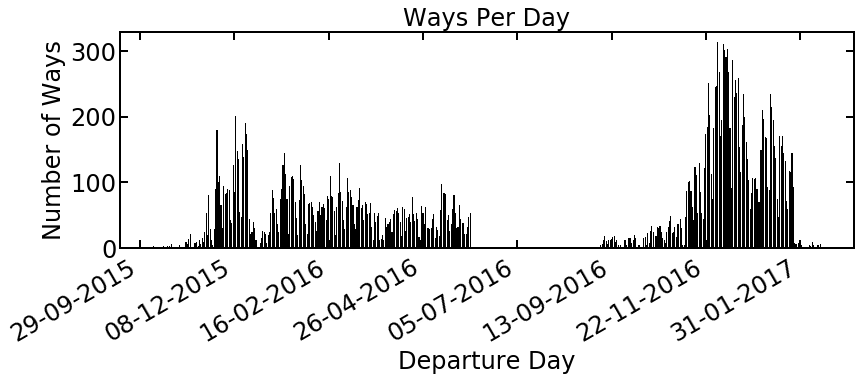

In [19]:
# https://stackoverflow.com/questions/17452179/not-write-out-all-dates-on-an-axis-matplotlib
fig = plt.figure(figsize=(12, 6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=70))
days_dt = [x.to_pydatetime() for x in list(days['time_begin_day'])]
plt.bar(days_dt, days['frequency'], align='center', color=color_full[0])
plt.gcf().autofmt_xdate()
ax = fig.add_subplot(111)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_title('Ways Per Day', fontsize=24)
ax.set_xlabel('Departure Day', fontsize=24)
ax.set_ylabel('Number of Ways', fontsize=24)
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.35, top=0.85)
#plt.savefig('WaysPerDay.pdf')

### Hours

In [20]:
ways['time_begin_hour'] = ways['time_begin'].str[11:13]
time_begin_hour = ways.groupby('time_begin_hour').size().sort_index()
time_begin_hour = pd.concat([pd.Series(time_begin_hour.index.tolist()), pd.Series(time_begin_hour.tolist())], axis=1)
time_begin_hour.columns = ['time_begin_hour', 'frequency']

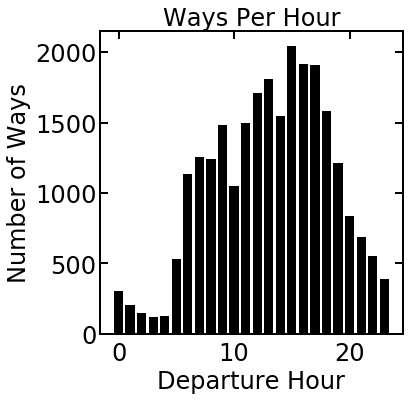

In [21]:
# https://stackoverflow.com/questions/17452179/not-write-out-all-dates-on-an-axis-matplotlib
fig = plt.figure(figsize=(6, 6))
hours = [x for x in range(0, 24)]
plt.bar(hours, time_begin_hour['frequency'], align='center', color=color_full[0])
ax = fig.add_subplot(111)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_title('Ways Per Hour', fontsize=24)
ax.set_xlabel('Departure Hour', fontsize=24)
ax.set_ylabel('Number of Ways', fontsize=24)
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.15, top=0.85)
#plt.savefig('WaysPerHour.pdf')

### Number of Ways

In [22]:
e = len(ways)
e

25279

### Number of Tracks

In [23]:
f = len(set(ways['track_id']))
f

14604

### Number of Users

In [24]:
u = len(set(ways['user_id']))
u

160

### Number of Ways Per User

In [25]:
epu = ways.groupby('user_id').size().tolist()

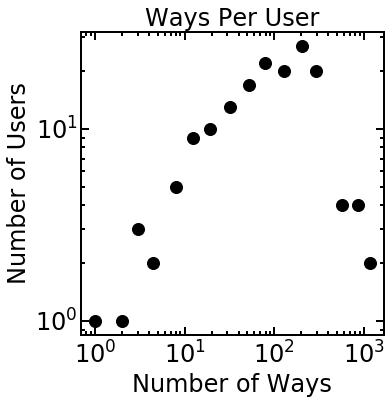

In [26]:
plot_distribution(l=epu, xlabel='Number of Ways', ylabel='Number of Users', title='Ways Per User', type='hist')
#plt.savefig('WaysPerUser.pdf')

### Average Number of Ways Per User

In [27]:
round(e/u, 1)

158.0

### Number of Tracks Per User

In [28]:
ways_ways = ways[['track_id', 'user_id']].drop_duplicates()

In [29]:
fpu = ways_ways.groupby('user_id').size().tolist()

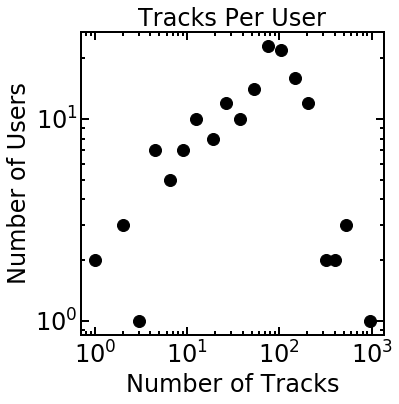

In [30]:
plot_distribution(l=fpu, xlabel='Number of Tracks', ylabel='Number of Users', title='Tracks Per User', type='hist')
#plt.savefig('TracksPerUser.pdf')

### Average Number of Tracks Per User

In [31]:
round(f/u, 1)

91.3

### Number of Ways Per Track

In [32]:
epf = ways.groupby('track_id').size().tolist()

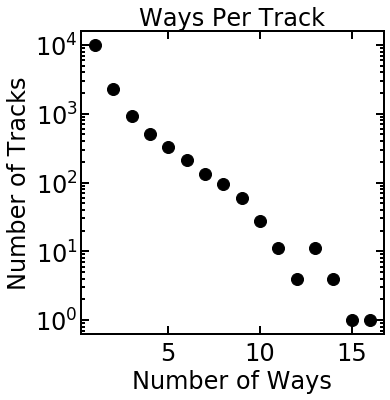

In [33]:
plot_distribution(l=epf, xlabel='Number of Ways', ylabel='Number of Tracks', title='Ways Per Track', type='hist', binning=False, scaling=False)
#plt.savefig('WaysPerTrack.pdf')

### Duration of Ways

### Duration of Tracks

### Duration of Rests

## Data Description (Resting Points)
### Load Data

In [34]:
points = pd.read_csv('../data/particles_resting_2018_v2.txt', delimiter = ';')

In [35]:
points.head()

,id,type,p1_x,p1_y,p2_x,p2_y,time_begin,time_end,user_id,mp_id_p,mp_id_n,location,name,level
0,50296639,small,12.975220,50.986162,12.977208,50.986273,2015-10-09 13:57:43,2015-10-09 13:59:30,2,632049,632050,373,Stadt Mittweida,Gemeinde
1,50296641,small,12.978933,50.982947,12.978970,50.982907,2015-10-12 14:40:46,2015-10-12 14:43:34,2,632051,632052,373,Stadt Mittweida,Gemeinde
2,50296643,small,13.116551,51.120702,13.118111,51.120523,2015-10-22 18:30:41,2015-10-22 18:31:12,2,632053,632054,396,Stadt Döbeln,Gemeinde
3,50296645,small,13.131141,51.114338,13.118115,51.122708,2015-10-22 20:55:40,2015-10-22 21:01:20,2,632055,632056,396,Stadt Döbeln,Gemeinde
4,50296649,small,12.971544,50.985375,12.972673,50.985403,2015-11-02 13:29:47,2015-11-02 13:36:13,2,632059,632060,373,Stadt Mittweida,Gemeinde


### Missing Data

In [36]:
points['p1_x'].isnull().values.any()

False

In [37]:
points['p1_y'].isnull().values.any()

False

In [38]:
points['p2_x'].isnull().values.any()

True

In [39]:
points['p2_y'].isnull().values.any()

True

In [40]:
points.dropna(subset=['p2_x', 'p2_y'], inplace=True)

### Communities

In [41]:
community = points.groupby('name').size().sort_values(ascending=False)
community.head()

name
Stadt Leipzig      21359
Stadt Mittweida    13603
Stadt Chemnitz     10947
Lichtenau            460
Altmittweida         386
dtype: int64

### Match of Two Coordinates Given Coordinate Resolution
Resting points are always pairs of locations. For example, while waiting for a tram connection, people may walk along the station; at home, people may move (their cell phone) from living room to kitchen. The first point in a pair (p1) is the location where the previous track terminated, the second (p2) is the location where the next track originates. The precision of GPS coordinates is given <a href='https://wiki.openstreetmap.org/wiki/DE:Genauigkeit_von_Koordinaten'>here</a>.

How many pairs match, are identical, at which coordinate resolution?

In [42]:
#points['p1_x'] = points['p1_x'].astype('str')
#points['p1_y'] = points['p1_y'].astype('str')
#points['p2_x'] = points['p2_x'].astype('str')
#points['p2_y'] = points['p2_y'].astype('str')

In [43]:
points_small = points[points['type'] == 'small']
points_large = points[points['type'] == 'large']

In [44]:
matches = []
for i in range(0, 9):
    matches.append(sum((round(points['p1_x'], i) == round(points['p2_x'], i)) & (round(points['p1_y'], i) == round(points['p2_y'], i))))
matches_small = []
for i in range(0, 9):
    matches_small.append(sum((round(points_small['p1_x'], i) == round(points_small['p2_x'], i)) & (round(points_small['p1_y'], i) == round(points_small['p2_y'], i))))
matches_large = []
for i in range(0, 9):
    matches_large.append(sum((round(points_large['p1_x'], i) == round(points_large['p2_x'], i)) & (round(points_large['p1_y'], i) == round(points_large['p2_y'], i))))

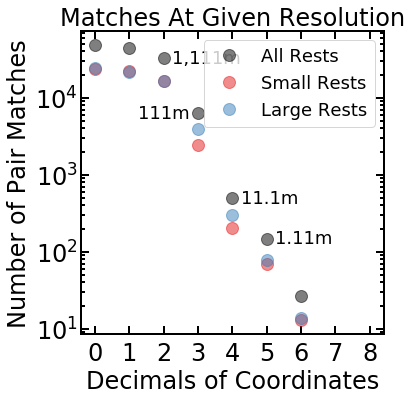

In [45]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.plot(range(0, 9), matches, marker='o', markersize=12, color=color_full[0], ls='', alpha=0.5, label='All Rests')
ax.plot(range(0, 9), matches_small, marker='o', markersize=12, color=color_full[1], ls='', alpha=0.5, label='Small Rests')
ax.plot(range(0, 9), matches_large, marker='o', markersize=12, color=color_full[2], ls='', alpha=0.5, label='Large Rests')
ax.annotate('1.11m', xy=(5+0.25, matches[5]), va='center', fontsize=18)
ax.annotate('11.1m', xy=(4+0.25, matches[4]), va='center', fontsize=18)
ax.annotate('111m', xy=(1+0.25, matches[3]), va='center', fontsize=18)
ax.annotate('1,111m', xy=(2+0.25, matches[2]), va='center', fontsize=18)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_yscale('log')
ax.set_title('Matches At Given Resolution', fontsize=24)
ax.set_xlabel('Decimals of Coordinates', fontsize=24)
ax.set_ylabel('Number of Pair Matches', fontsize=24)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.35, right=0.95, bottom=0.15, top=0.85)
#plt.savefig('MatchesAtGivenResolution.pdf')

How many distinct coordinates are there at which resolution?

In [46]:
p1 = pd.DataFrame(points[['p1_x', 'p1_y']])
p1.rename(columns={'p1_x':'x', 'p1_y':'y'}, inplace=True)
p2 = pd.DataFrame(points[['p2_x', 'p2_y']])
p2.rename(columns={'p2_x':'x', 'p2_y':'y'}, inplace=True)
X = p1.append(p2).reset_index(drop=True)

In [47]:
coordinates = []
for i in range(0, 9):
    Z = X.copy()
    Z['x'] = round(Z['x'], i)
    Z['y'] = round(Z['y'], i)
    Z.drop_duplicates(inplace=True)
    coordinates.append(len(Z))

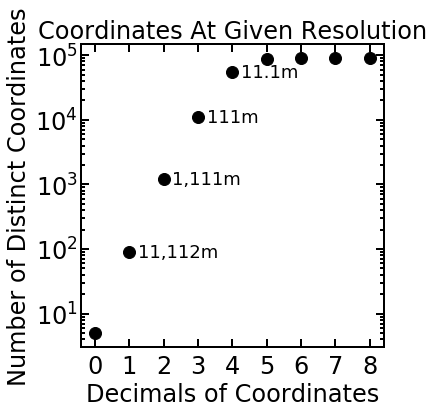

In [48]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.plot(range(0, 9), coordinates, marker='o', markersize=12, color=color_full[0], ls='')
ax.annotate('11.1m', xy=(4+0.25, coordinates[4]), va='center', fontsize=18)
ax.annotate('111m', xy=(3+0.25, coordinates[3]), va='center', fontsize=18)
ax.annotate('1,111m', xy=(2+0.25, coordinates[2]), va='center', fontsize=18)
ax.annotate('11,112m', xy=(1+0.25, coordinates[1]), va='center', fontsize=18)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_yscale('log')
ax.set_title('Coordinates At Given Resolution', fontsize=24)
ax.set_xlabel('Decimals of Coordinates', fontsize=24)
ax.set_ylabel('Number of Distinct Coordinates', fontsize=24)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.35, right=0.95, bottom=0.15, top=0.85)
#plt.savefig('CoordinatesAtGivenResolution.pdf')

### Clustering
To reduce the number of coordinates, we use a combination of rounding to three or four decimals and clustering.

Chose number of decimals:

In [49]:
i = 3

In [50]:
points['p1_x'] = round(points['p1_x'], i)
points['p1_y'] = round(points['p1_y'], i)
points['p2_x'] = round(points['p2_x'], i)
points['p2_y'] = round(points['p2_y'], i)

In [51]:
X['x'] = round(X['x'], i)
X['y'] = round(X['y'], i)
X.drop_duplicates(inplace=True) # IS THAT CORRECT?

In [52]:
X = np.array(X)

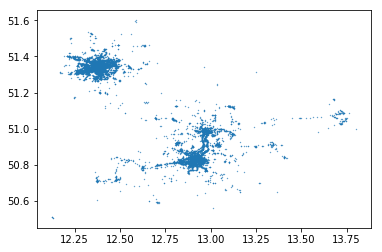

In [53]:
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=0.1)

#### KMeans

In [54]:
#ks = [int(x) for x in np.linspace(len(points)/2000, len(points)/20, 10)]
#scores = []
#for k in ks:
#    print(k)
#    clust = KMeans(n_clusters=k)
#    y = clust.fit_predict(X)
#    scores.append(metrics.silhouette_score(X, y, metric='euclidean'))
#plt.plot(ks, scores)

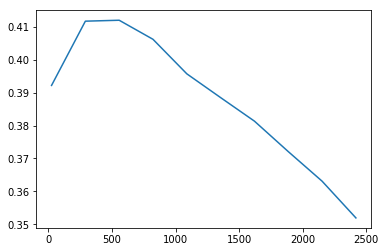

In [55]:
plt.plot([24, 290, 556, 822, 1088, 1354, 1620, 1886, 2152, 2418], [0.39217216439370495, 0.41167420012324019, 0.41195612344442595, 0.40616983065314582, 0.39569641215894485, 0.38847427355993253, 0.38133096093397117, 0.37209044454927986, 0.36311484745853811, 0.35196442744918077]) # three decimals
#plt.plot() # four decimals

In [56]:
#ks = [int(x) for x in np.linspace(100, 1000, 37)]
#scores = []
#for k in ks:
#    print(k)
#    clust = KMeans(n_clusters=k)
#    y = clust.fit_predict(X)
#    scores.append(metrics.silhouette_score(X, y, metric='euclidean'))
#plt.plot(ks, scores)

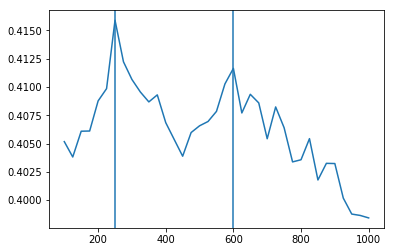

In [57]:
plt.plot([100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000], [0.40517120483009228, 0.40381340290084156, 0.40609193031432139, 0.40611021872282482, 0.40876936278846626, 0.40985660806688978, 0.41590263358562141, 0.41222891042600734, 0.41066580736758601, 0.40955674987118229, 0.40868337413296857, 0.40930352250192276, 0.40684753052305173, 0.40536269613754161, 0.40388203645936188, 0.40597373722540636, 0.4065709994946437, 0.40694996086062524, 0.40784572739982738, 0.41027243144026776, 0.41164802603318618, 0.40770682613233744, 0.40935498983056767, 0.40859403500589281, 0.40542630428997284, 0.40823835798659885, 0.40640100295461901, 0.40337890908017598, 0.40356891106001436, 0.40543470934598791, 0.40178130332318279, 0.40325179972679359, 0.40323359606025561, 0.40017807188481025, 0.39876714593695489, 0.39864582106111601, 0.39842684665412764]) # three decimals
plt.axvline(250) # three decimals
plt.axvline(600) # three decimals
#plt.plot() # four decimals

In [58]:
clust = KMeans(n_clusters=600)
y_km = clust.fit_predict(X)

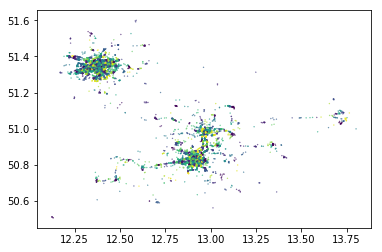

In [59]:
plt.scatter(X[:, 0], X[:, 1], c=y_km, s=0.1)

(50.789338, 50.889337999999995)

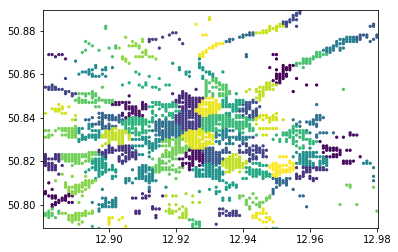

In [60]:
# chemnitz hbf (11,112m x 11,112m)
plt.scatter(X[:, 0], X[:, 1], c=y_km, s=5)
plt.xlim(12.930177-0.05, 12.930177+0.05)
plt.ylim(50.839338-0.05, 50.839338+0.05)

(50.662000000000006, 50.762)

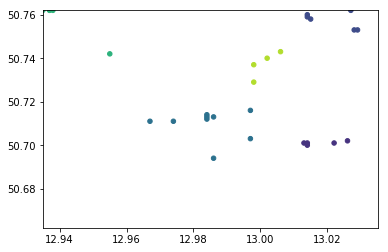

In [61]:
# ? (11,112m x 11,112m)
plt.scatter(X[:, 0], X[:, 1], c=y_km, s=20)
plt.xlim(12.985-0.05, 12.985+0.05)
plt.ylim(50.712-0.05, 50.712+0.05)

#### AgglomerativeClustering

In [62]:
#ks = [int(x) for x in np.linspace(len(points)/2000, len(points)/20, 10)]
#scores = []
#for k in ks:
#    print(k)
#    clust = AgglomerativeClustering(n_clusters=k)
#    y = clust.fit_predict(X)
#    scores.append(metrics.silhouette_score(X, y, metric='euclidean'))
#plt.plot(ks, scores)

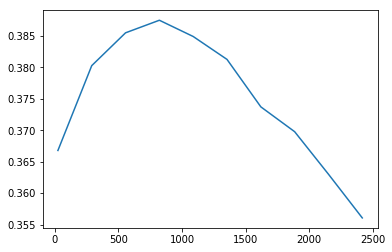

In [63]:
plt.plot([24, 290, 556, 822, 1088, 1354, 1620, 1886, 2152, 2418], [0.3667741751821002, 0.38026544073544916, 0.38548560223459655, 0.38748449391815043, 0.38490007182737329, 0.38125589168757573, 0.37371264162934836, 0.3697620054652897, 0.36299866951542681, 0.35604958773710849]) # three decimals
#plt.plot() # four decimals

In [64]:
#ks = [int(x) for x in np.linspace(100, 1000, 37)]
#scores = []
#for k in ks:
#    print(k)
#    clust = KMeans(n_clusters=k)
#    y = clust.fit_predict(X)
#    scores.append(metrics.silhouette_score(X, y, metric='euclidean'))
#plt.plot(ks, scores)

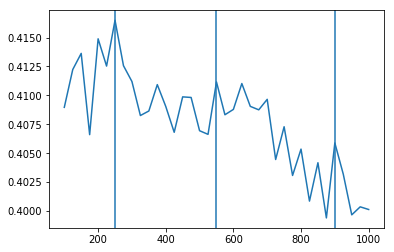

In [65]:
plt.plot([100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325, 1350, 1375, 1400][:37], [0.40896452333463373, 0.41223052073682154, 0.41362790308411107, 0.40660372953067281, 0.414886950980909, 0.41253149709255099, 0.41649220772219875, 0.41256344766936826, 0.41119757063535822, 0.4082568684691229, 0.40864820793230444, 0.41092716400035773, 0.40904463888924014, 0.40680822494518065, 0.40986973917265873, 0.40981802335673173, 0.40694425848883947, 0.40662993070602771, 0.41115909815692131, 0.40832363190189302, 0.40878602634883815, 0.41102135144599566, 0.40904868697673918, 0.4087494562972655, 0.40965611695680898, 0.40445710444512012, 0.40728745305352981, 0.40307671890934432, 0.40535381876912724, 0.40086124448708932, 0.40417705397008036, 0.39940731955252129, 0.40588626665878585, 0.40318250984121823, 0.39967236507815002, 0.4003653559897784, 0.40013491947084112, 0.39956627063544514, 0.39679734154353219, 0.39671098270729122, 0.3954877368959771, 0.39363932267307877, 0.39630131954959119, 0.39479863936136222, 0.39160923571504047, 0.39251527953606974, 0.38859940601431048, 0.39094078527594611, 0.39113011339081871, 0.39020886243029251, 0.38688828867303066, 0.38842861506861515, 0.38649208873207197][:37]) # three decimals
plt.axvline(250) # three decimals
plt.axvline(550) # three decimals
plt.axvline(900) # three decimals
#plt.plot() # four decimals

In [66]:
clust = AgglomerativeClustering(n_clusters=550)
y_ac = clust.fit_predict(X)

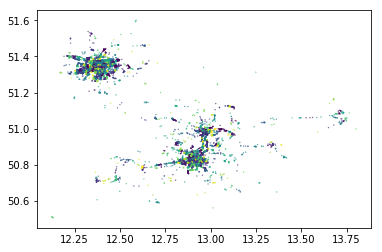

In [67]:
plt.scatter(X[:, 0], X[:, 1], c=y_ac, s=0.1)

(50.789338, 50.889337999999995)

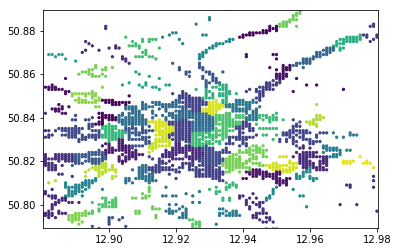

In [68]:
# chemnitz hbf (11,112m x 11,112m)
plt.scatter(X[:, 0], X[:, 1], c=y_ac, s=5)
plt.xlim(12.930177-0.05, 12.930177+0.05)
plt.ylim(50.839338-0.05, 50.839338+0.05)

(50.662000000000006, 50.762)

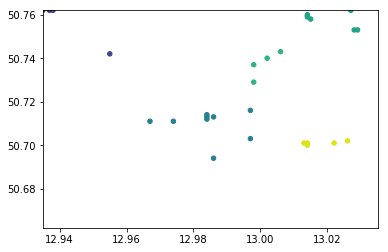

In [69]:
# ? (11,112m x 11,112m)
plt.scatter(X[:, 0], X[:, 1], c=y_ac, s=20)
plt.xlim(12.985-0.05, 12.985+0.05)
plt.ylim(50.712-0.05, 50.712+0.05)

#### DBScan

In [70]:
clust = DBSCAN(eps=0.005, min_samples=2)
y_dbs = clust.fit_predict(X)

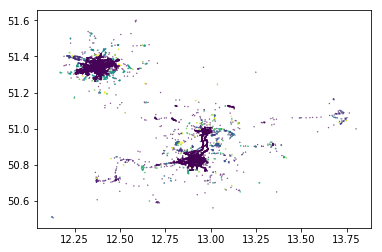

In [71]:
plt.scatter(X[:, 0], X[:, 1], c=y_dbs, s=0.1)

(50.789338, 50.889337999999995)

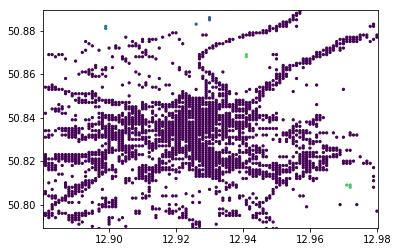

In [72]:
# chemnitz hbf (11,112m x 11,112m)
plt.scatter(X[:, 0], X[:, 1], c=y_dbs, s=5)
plt.xlim(12.930177-0.05, 12.930177+0.05)
plt.ylim(50.839338-0.05, 50.839338+0.05)

(50.662000000000006, 50.762)

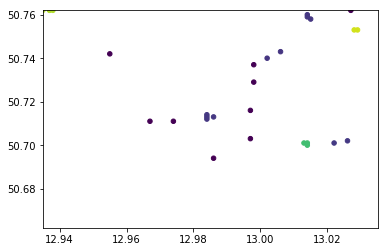

In [73]:
# ? (11,112m x 11,112m)
plt.scatter(X[:, 0], X[:, 1], c=y_dbs, s=20)
plt.xlim(12.985-0.05, 12.985+0.05)
plt.ylim(50.712-0.05, 50.712+0.05)

Choose clustering solution:

In [74]:
cluster = y_ac
cluster_label = 'Agglomerative'

Append chosen solution to dataframe:

In [75]:
coordinates = pd.DataFrame(X, columns=['x', 'y'])

In [76]:
coordinates['cluster'] = cluster

In [77]:
coordinates.head()

,x,y,cluster
0,12.975,50.986,36
1,12.979,50.983,89
2,13.117,51.121,52
3,13.131,51.114,52
4,12.972,50.985,36


In [78]:
coordinates.to_csv('../data/coordinates_dec3_ac550.txt', sep='\t', index=False)

In [79]:
points.head()

,id,type,p1_x,p1_y,p2_x,p2_y,time_begin,time_end,user_id,mp_id_p,mp_id_n,location,name,level
0,50296639,small,12.975,50.986,12.977,50.986,2015-10-09 13:57:43,2015-10-09 13:59:30,2,632049,632050,373,Stadt Mittweida,Gemeinde
1,50296641,small,12.979,50.983,12.979,50.983,2015-10-12 14:40:46,2015-10-12 14:43:34,2,632051,632052,373,Stadt Mittweida,Gemeinde
2,50296643,small,13.117,51.121,13.118,51.121,2015-10-22 18:30:41,2015-10-22 18:31:12,2,632053,632054,396,Stadt Döbeln,Gemeinde
3,50296645,small,13.131,51.114,13.118,51.123,2015-10-22 20:55:40,2015-10-22 21:01:20,2,632055,632056,396,Stadt Döbeln,Gemeinde
4,50296649,small,12.972,50.985,12.973,50.985,2015-11-02 13:29:47,2015-11-02 13:36:13,2,632059,632060,373,Stadt Mittweida,Gemeinde


In [80]:
points_clusters = pd.merge(left=points, right=coordinates, left_on=['p1_x', 'p1_y'], right_on=['x', 'y'])
points_clusters.rename(columns={'cluster':'p1_cluster'}, inplace=True)
points_clusters = pd.merge(left=points_clusters, right=coordinates, left_on=['p2_x', 'p2_y'], right_on=['x', 'y'])
points_clusters.rename(columns={'cluster':'p2_cluster'}, inplace=True)
points_clusters.drop(['x_x', 'x_y', 'y_x', 'y_y'], axis=1, inplace=True)

In [81]:
points_clusters.head()

,id,type,p1_x,p1_y,p2_x,p2_y,time_begin,time_end,user_id,mp_id_p,mp_id_n,location,name,level,p1_cluster,p2_cluster
0,50296639,small,12.975,50.986,12.977,50.986,2015-10-09 13:57:43,2015-10-09 13:59:30,2,632049,632050,373,Stadt Mittweida,Gemeinde,36,36
1,50300383,small,12.975,50.986,12.977,50.986,2016-07-12 20:06:13,2016-07-12 20:11:58,32,645143,645144,373,Stadt Mittweida,Gemeinde,36,36
2,50312562,small,12.975,50.986,12.977,50.986,2017-01-13 07:06:26,2017-01-13 07:07:13,128,679300,679301,373,Stadt Mittweida,Gemeinde,36,36
3,50337994,small,12.975,50.986,12.977,50.986,2016-11-29 11:26:46,2016-11-29 11:28:19,346,670816,670817,373,Stadt Mittweida,Gemeinde,36,36
4,50340131,small,12.975,50.986,12.977,50.986,2016-12-13 15:41:05,2016-12-13 15:42:00,391,674481,674482,373,Stadt Mittweida,Gemeinde,36,36


## Creation of Network Data
The most simple network is the one that uses the coarse <font face='Courier'>start_location</font> and <font face='Courier'>end_location</font> given in the <font face='Courier'>ways</font> table:

In [82]:
ways_locations = ways[['time_begin', 'time_end', 'start_location', 'end_location', 'type', 'speed']]
ways_locations.rename(columns={'start_location':'location_begin', 'end_location':'location_end'}, inplace=True)

In [83]:
ways_locations.head()

,time_begin,time_end,location_begin,location_end,type,speed
0,2015-11-04 10:12:28,2015-11-04 11:06:35,Stadt Mittweida,Stadt Mittweida,foot,0.64
1,2015-11-04 11:06:35,2015-11-04 11:06:43,Stadt Mittweida,Stadt Mittweida,car,785.12
3,2015-11-04 12:56:46,2015-11-04 12:57:59,Stadt Mittweida,Stadt Mittweida,foot,2.59
4,2015-11-04 12:57:59,2015-11-04 13:11:34,Stadt Mittweida,Stadt Mittweida,foot,1.95
5,2015-11-04 13:11:34,2015-11-04 13:14:24,Stadt Mittweida,Stadt Mittweida,car,22.64


In [84]:
#ways_locations.to_csv('../data/ways_locations.txt', sep='\t', index=False)

Higher resolution is only obtained using GPS coordinates. First, we merge the ways and points tables:

In [85]:
ways['prev_rp'] = ways['prev_rp'].astype(int)
ways['next_rp'] = ways['next_rp'].astype(int)

In [86]:
ways_clusters = pd.merge(left=ways, right=points_clusters[['id', 'p2_cluster']], left_on='prev_rp', right_on='id')
ways_clusters = pd.merge(left=ways_clusters, right=points_clusters[['id', 'p1_cluster']], left_on='next_rp', right_on='id')
ways_clusters = ways_clusters[['time_begin', 'time_end', 'p2_cluster', 'p1_cluster', 'type', 'speed']]
ways_clusters.rename(columns={'p2_cluster':'cluster_begin', 'p1_cluster':'cluster_end'}, inplace=True)

In [87]:
ways_clusters.head()

,time_begin,time_end,cluster_begin,cluster_end,type,speed
0,2015-11-04 10:12:28,2015-11-04 11:06:35,36,36,foot,0.64
1,2015-11-04 11:06:35,2015-11-04 11:06:43,36,36,car,785.12
2,2015-11-04 12:56:46,2015-11-04 12:57:59,36,36,foot,2.59
3,2015-11-04 12:57:59,2015-11-04 13:11:34,36,36,foot,1.95
4,2015-11-04 13:11:34,2015-11-04 13:14:24,189,189,car,22.64


Create a nodelist:

In [91]:
nodelist = pd.DataFrame(ways_clusters['cluster_begin'].append(ways_clusters['cluster_end']), columns=['cluster']).drop_duplicates().reset_index(drop=True)
nodelist['id'] = nodelist.index
nodelist = nodelist[['id', 'cluster']]
nodelist.to_csv('../data/nodelist_dec' + str(i) + '_clu' + cluster_label + '.txt', sep='\t', index=False)

In [95]:
nodelist.head()

,id,cluster
0,0,36
1,1,189
2,2,233
3,3,506
4,4,98


Create edgelist:

In [107]:
edgelist = pd.merge(left=ways_clusters, right=nodelist, left_on='cluster_begin', right_on='cluster')
edgelist = edgelist.rename(columns={'id':'cluster_id_begin'})
edgelist = pd.merge(left=edgelist, right=nodelist, left_on='cluster_end', right_on='cluster')
edgelist = edgelist.rename(columns={'id':'cluster_id_end'})
edgelist = edgelist[['time_begin', 'time_end', 'cluster_id_begin', 'cluster_id_end', 'type', 'speed']]
edgelist.to_csv('../data/edgelist_dec' + str(i) + '_clu' + cluster_label + '.txt', sep='\t', index=False)

In [105]:
edgelist.head()

,time_begin,time_end,cluster_id_begin,cluster_id_end,type,speed
0,2015-11-04 10:12:28,2015-11-04 11:06:35,0,0,foot,0.64
1,2015-11-04 11:06:35,2015-11-04 11:06:43,0,0,car,785.12
2,2015-11-04 12:56:46,2015-11-04 12:57:59,0,0,foot,2.59
3,2015-11-04 12:57:59,2015-11-04 13:11:34,0,0,foot,1.95
4,2015-11-04 11:55:18,2015-11-04 12:10:44,0,0,foot,0.41


# OLD

In [109]:
xxx

NameError: name 'xxx' is not defined

Higher resolution is only obtained using GPS coordinates. First, we merge the ways and points tables:

In [ ]:
ways['prev_rp'] = ways['prev_rp'].astype(int)
ways['next_rp'] = ways['next_rp'].astype(int)

In [ ]:
ways_coordinates = pd.merge(left=ways, right=points[['id', 'p2_x', 'p2_y']], left_on='prev_rp', right_on='id')
ways_coordinates = pd.merge(left=ways_coordinates, right=points[['id', 'p1_x', 'p1_y']], left_on='next_rp', right_on='id')
ways_coordinates = ways_coordinates[['time_begin', 'time_end', 'p2_x', 'p2_y', 'p1_x', 'p1_y', 'type', 'speed']]
ways_coordinates.rename(columns={'p2_x':'coordinate_begin_x', 'p2_y':'coordinate_begin_y', 'p1_x':'coordinate_end_x', 'p1_y':'coordinate_end_y'}, inplace=True)
ways_coordinates = ways_coordinates[(ways_coordinates['coordinate_begin_x'] != 'nan') & (ways_coordinates['coordinate_begin_y'] != 'nan') & (ways_coordinates['coordinate_end_x'] != 'nan') & (ways_coordinates['coordinate_end_y'] != 'nan')]

In [ ]:
ways_coordinates

Then, we create nodelists and edgelists for variable resolutions of GPS coordinates:

In [ ]:
nodes = []
for i in range(0, 9):
    # create nodelists
    ways_coordinates_dec = ways_coordinates.copy()
    ways_coordinates_dec['coordinate_begin_x'] = ways_coordinates_dec['coordinate_begin_x'].str[:i+3]
    ways_coordinates_dec['coordinate_begin_y'] = ways_coordinates_dec['coordinate_begin_y'].str[:i+3]
    ways_coordinates_dec['coordinate_end_x'] = ways_coordinates_dec['coordinate_end_x'].str[:i+3]
    ways_coordinates_dec['coordinate_end_y'] = ways_coordinates_dec['coordinate_end_y'].str[:i+3]
    ways_coordinates_begin_dec = ways_coordinates_dec[['coordinate_begin_x', 'coordinate_begin_y']].rename(columns={'coordinate_begin_x':'coordinate_x', 'coordinate_begin_y':'coordinate_y'})
    ways_coordinates_end_dec = ways_coordinates_dec[['coordinate_end_x', 'coordinate_end_y']].rename(columns={'coordinate_end_x':'coordinate_x', 'coordinate_end_y':'coordinate_y'})
    points_coordinates_dec = pd.concat([ways_coordinates_begin_dec, ways_coordinates_end_dec]).drop_duplicates().reset_index(drop=True)
    points_coordinates_dec['id'] = points_coordinates_dec.index
    points_coordinates_dec = points_coordinates_dec[['id', 'coordinate_x', 'coordinate_y']]
    points_coordinates_dec.to_csv('../data/points_coordinates_dec' + str(i) + '.txt', sep='\t', index=False)
    # store number of distinct nodes
    nodes.append(len(points_coordinates_dec))
    # create edgelists
    ways_coordinates_dec = pd.merge(left=ways_coordinates_dec, right=points_coordinates_dec, left_on=['coordinate_begin_x', 'coordinate_begin_y'], right_on=['coordinate_x', 'coordinate_y'])
    ways_coordinates_dec = ways_coordinates_dec.rename(columns={'id':'coordinate_id_begin'})
    ways_coordinates_dec = pd.merge(left=ways_coordinates_dec, right=points_coordinates_dec, left_on=['coordinate_end_x', 'coordinate_end_y'], right_on=['coordinate_x', 'coordinate_y'])
    ways_coordinates_dec = ways_coordinates_dec.rename(columns={'id':'coordinate_id_end'})
    ways_coordinates_dec = ways_coordinates_dec[['time_begin', 'time_end', 'coordinate_id_begin', 'coordinate_id_end', 'type', 'speed']]
    ways_coordinates_dec.to_csv('../data/ways_coordinates_dec' + str(i) + '.txt', sep='\t', index=False)